## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional, Set
from metric_tests import run_tests

%matplotlib inline

C:\Users\bodyk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [3]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [4]:
pd.to_datetime(df['last_watch_dt']).min()

Timestamp('2021-03-13 00:00:00')

In [5]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
3782746,369107,12250,51,119,2.0
4906601,900874,4250,142,2257,44.0
960529,73395,13610,141,200,4.0
1164117,151018,3182,129,3199,49.0
2922662,96758,5650,117,1398,25.0


Сделаем разбиение по времени

<Axes: >

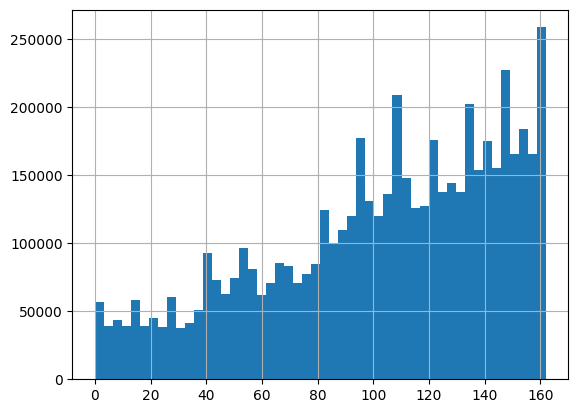

In [6]:
df.last_watch_dt.hist(bins=50)

In [7]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [8]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [9]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [10]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
11,988709,7571,116,6558,100.0
55,897955,13933,88,6394,97.0
58,739920,3190,145,3349,48.0
97,1061176,13763,150,1084,16.0
145,141072,7308,119,8657,100.0


In [11]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8..."
1,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5..."
2,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ..."
3,446,"[(13865, 105)]"
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)..."


In [12]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]"
1,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]"
2,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]"
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,..."


In [13]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[2012, 956, 2059]"
1,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[2012, 956, 2059]"
2,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[2012, 956, 2059]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[2012, 956, 2059]"
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[2012, 956, 2059]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [14]:
def ap_metric(
    gt_set: Set[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
        
    predictions = predictions[:topn]    
    r = np.array([int(x in gt_set) for x in predictions])
    p = np.cumsum(r)/(np.arange(len(r))+1)
    AP = np.sum(r * p)

    return AP/min(topn, len(gt_set))

def rr_metric(
    gt_set: Set[int],
    predictions: List[int],
    topn: Optional[int]=None
):

    predictions = predictions[:topn]    
    r = np.array([int(x in gt_set) for x in predictions])
    rank = np.where(r==1)[0]

    if topn is None:
        topn = len(predictions)

    if any(rank):
        rr = 1/(rank[0] + 1)
    else:
        rr = 0
    return rr

def hr_metric(
    gt_set: Set[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]    
    r = np.array([int(x in gt_set) for x in predictions])
    rank = np.where(r==1)[0]
    if any(rank):
        return 1
    else:
        return 0


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [15]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [16]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions', topn=None):

    metric_values = []

    # Если model_preds — это строка, берем предсказания из колонки df
    if isinstance(model_preds, str):
        preds_list = df[model_preds].tolist()
    # Если model_preds — это список, используем его напрямую
    else:
        preds_list = model_preds

    # Проверяем, что количество предсказаний совпадает с количеством строк в df
    if len(preds_list) != len(df):
        raise ValueError("Количество предсказаний должно совпадать с количеством строк в df.")

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = preds_list[idx]
        gt_set = set(gt_items)

        if topn is None:
            topn = len(predictions)

        ap = ap_metric(gt_set, predictions, topn)
        rr = rr_metric(gt_set, predictions, topn)
        hr = hr_metric(gt_set, predictions, topn)

        metric_values.append((ap, rr, hr))

    return {
        'map': np.mean([x[0] for x in metric_values]),
        'mrr': np.mean([x[1] for x in metric_values]),
        'hr': np.mean([x[2] for x in metric_values])
    }

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [17]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0003361111111111111, 'mrr': 0.0003833333333333333, 'hr': 0.0008}

In [18]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):
        
        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [19]:
pred_pops = evaluate_recommender(joined, model_preds='toppopular_recs')
pred_pops

{'map': 0.06601546025447216, 'mrr': 0.08212507936507936, 'hr': 0.232}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [20]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):

        current_date = 153

        counts = {}
        for _, row in df.iterrows():
            for item, data in row[col]:
                if (item in counts) and (current_date - data <= self.min_window):
                    counts[item] += 1
                elif current_date - data <= self.min_window:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [x[0] for x in counts]
        self.trained = True

toppop_recent = TopPopularWeighted(min_window = 4)
toppop_recent.fit(joined)

joined['toppopular_recent_recs'] = toppop_recent.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recent_recs
0,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 15297, 10440, 3734, 4151, 341, 7793, 13..."
1,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 15297, 10440, 3734, 4151, 341, 7793, 13..."
2,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 15297, 10440, 3734, 4151, 341, 7793, 13..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 15297, 10440, 3734, 4151, 341, 7793, 13..."
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 15297, 10440, 3734, 4151, 341, 7793, 13..."


Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [21]:
map_list = []
mrr_list = []
hr_list =[]
win_range = np.arange(1, 150, 1)
for min_window in win_range:
    toppop_recent = TopPopularWeighted(min_window = min_window)
    toppop_recent.fit(joined)

    joined['toppopular_recent_recs'] = toppop_recent.predict(joined)
    map_c, mrr_c, hr_c = evaluate_recommender(joined, model_preds='toppopular_recent_recs').values()
    map_list.append(map_c)
    mrr_list.append(mrr_c)
    hr_list.append(hr_c)

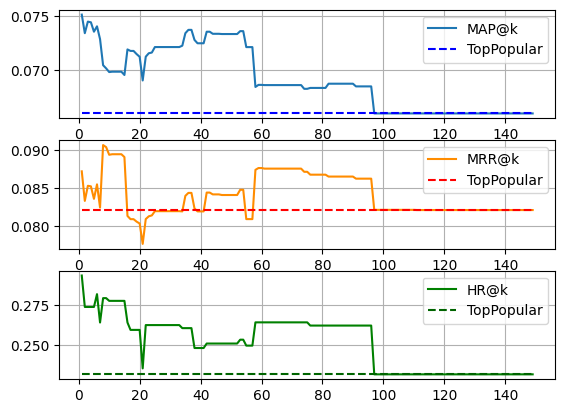

In [22]:
plt.subplot(3, 1, 1)
plt.plot(win_range, map_list, label='MAP@k')
plt.plot(win_range, pred_pops['map']*np.ones_like(win_range), '--', color='blue', label='TopPopular')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(win_range, mrr_list, label='MRR@k', color = 'darkorange')
plt.plot(win_range, pred_pops['mrr']*np.ones_like(win_range), '--', color='red', label='TopPopular')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(win_range, hr_list, label='HR@k', color='green')
plt.plot(win_range, pred_pops['hr']*np.ones_like(win_range), '--', color='darkgreen', label='TopPopular')
plt.grid(True)
plt.legend()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** 

`Судя по графикам, самое оптимальное значение - около 10 дней. Все три метрики находятся выше значения TopPopular. Если ориентироваться на MAP, то лучший размер окна - это месяц-полтора, видимо именно столько в среднем длится популярность фильмов. При увеличении окна, метрики, ожидаемо, стемятся к значению TopPopular`

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [23]:
map_list = []
mrr_list = []
hr_list =[]
k_range = np.arange(1, 21, 1)
for k in k_range:
    predictions = toppop.predict(joined)
    map_c, mrr_c, hr_c = evaluate_recommender(joined, model_preds='toppopular_recs', topn=k).values()
    map_list.append(map_c)
    mrr_list.append(mrr_c)
    hr_list.append(hr_c)

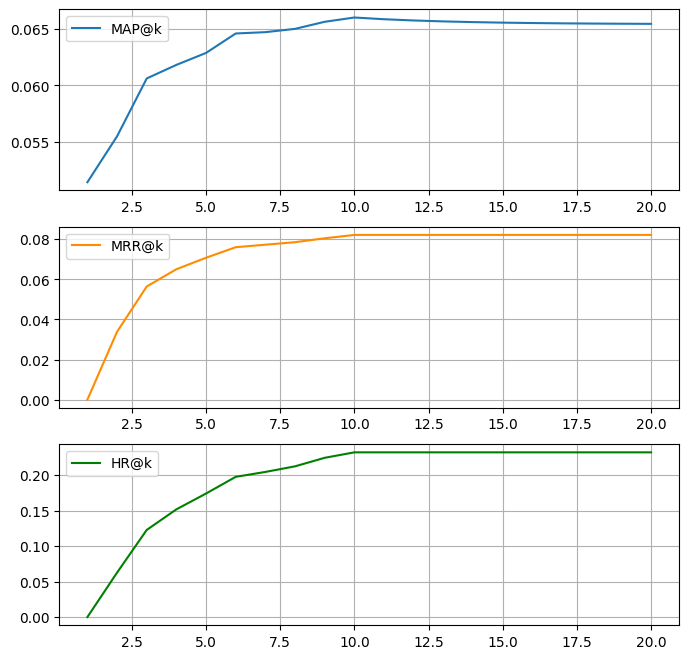

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(k_range, map_list, label='MAP@k')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(k_range, mrr_list, label='MRR@k', color = 'darkorange')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(k_range, hr_list, label='HR@k', color='green')
plt.grid(True)
plt.legend()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [25]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


In [26]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
# sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
# print(name, sampled_id)
# interactions.last_watch_dt.hist(bins=70)

Пример:

1917, item_id = 3402


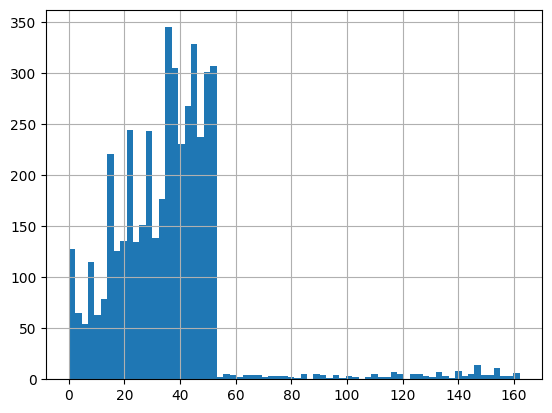

In [27]:
sampled_id = 3402
name = items.loc[items.item_id==sampled_id].title.values[0]
interactions = df.loc[df.item_id==sampled_id].copy()
print(f'{name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist(bins=70)
plt.show()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты? `С начала мая 2021 года`). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

`Искал с помощью ctrl + enter, и вывода названия и item_id`

101 далматинец, item_id = 5023


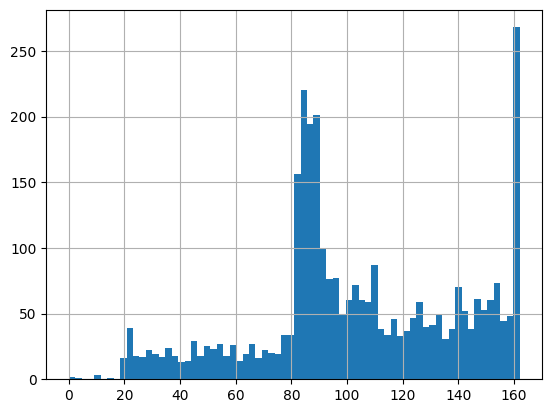

In [28]:
sampled_id = 5023
name = items.loc[items.item_id==sampled_id].title.values[0]
interactions = df.loc[df.item_id==sampled_id].copy()
print(f'{name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist(bins=70)
plt.show()

Перый пик 101 долматинца пришелся на май 2021 года - выход фильма Круэлла. А ыот второй пик в конце диапазона я объяснить не смогу(. Возможно, в этот омент он получил какую-то награду, может быть какой-то скандал с актерами, может всех закрыли на карантин и все начали смотреть новинки

Пираты Карибского Моря: Сундук Мертвеца, item_id = 14264


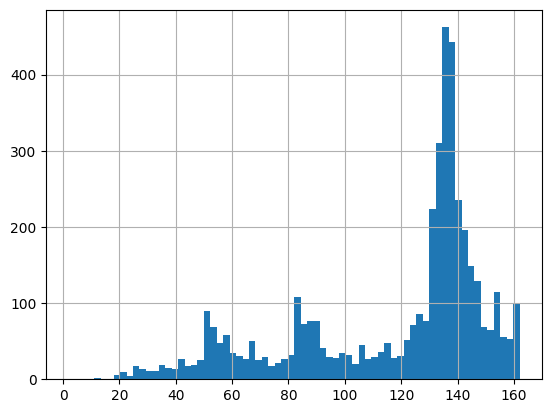

In [29]:
sampled_id = 14264
name = items.loc[items.item_id==sampled_id].title.values[0]
interactions = df.loc[df.item_id==sampled_id].copy()
print(f'{name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist(bins=70)
plt.show()

Пираты Карибского Моря. Вся серия этих фильмов достаточно популярна, но есть десяток дней, когда они были особенно популярны, а затем их популярность выровнялась к обычному уровню. По датам похоже, что это было в период суда по разводу Джонни Деппа

Королева, item_id = 12132


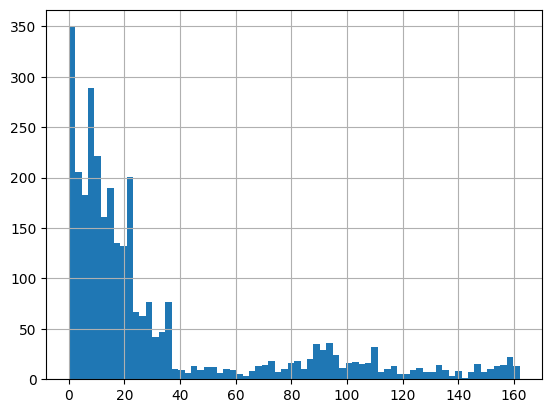

In [30]:
sampled_id = 12132
name = items.loc[items.item_id==sampled_id].title.values[0]
interactions = df.loc[df.item_id==sampled_id].copy()
print(f'{name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist(bins=70)
plt.show()

Есть три фильма с таким названием (2006, 2008 и 2020 годов). Предположу, что имеется в виду фильм 2006. Он про Елизавету 2 и Тони Блэра. Как раз в 2021 году выходил сезон популярного сериала Корона про это время. Видно, что фильм вышел до рассматриваемого диапазона и терял популярность достаточно медленно

Ледяной капкан, item_id = 4382


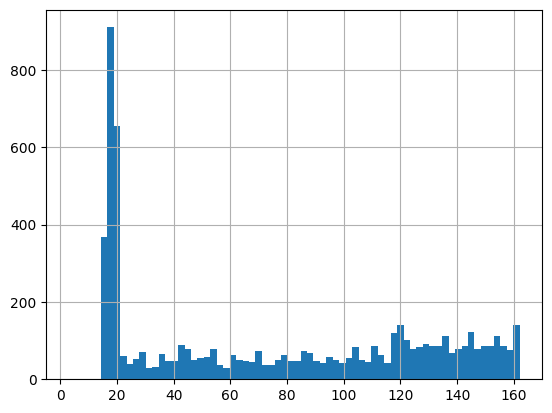

In [31]:
sampled_id = 4382
name = items.loc[items.item_id==sampled_id].title.values[0]
interactions = df.loc[df.item_id==sampled_id].copy()
print(f'{name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist(bins=70)
plt.show()

Паттерн, похожий на предыдущий, но тут пик длиться всего пару дней сразу после выхода, затем замирает на одном уровне. Такое 

Миньоны, item_id = 2954


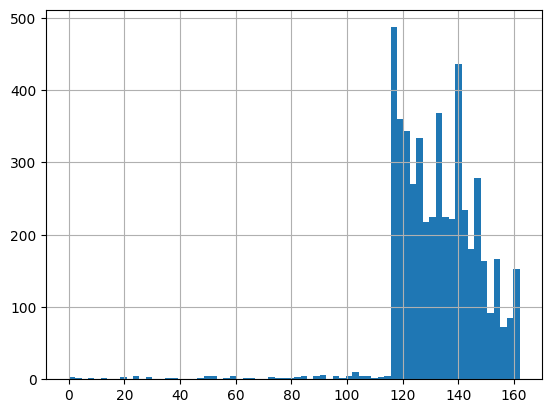

In [32]:
sampled_id = 2954
name = items.loc[items.item_id==sampled_id].title.values[0]
interactions = df.loc[df.item_id==sampled_id].copy()
print(f'{name}, item_id = {sampled_id}')
interactions.last_watch_dt.hist(bins=70)
plt.show()

Видимо, это первая часть Миньонов, которая было почти на нуле, но после выхода второй части стала популярнее и устойчиво сохраняет популярность

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [33]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    value_counts = df[col].value_counts()
    valid_items = value_counts[value_counts >= min_freq].index
    df = df[df[col].isin(valid_items)]
    return df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    filtered_df = df.copy()
    while True:
        filtered_df = df.copy()
        for col in cols:
            filtered_df = filter_column(filtered_df, col, min_freq)
        if len(filtered_df) == len(df):
            break
        else:
            df = filtered_df
    return df

filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'])

In [34]:
filtered_train['item_id'].value_counts().min()

5

In [35]:
filtered_train['user_id'].value_counts().min()

5

In [36]:
len(filtered_train)/len(train_df)

0.8744185293951088

In [37]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, item2id, user2id, id2item, id2user

filtered_train, item2id, user2id, id2item, id2user = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2264968,1791,1921,143,182,3.0
417174,3683,2154,152,214,3.0
48004,797,286,125,333,0.0
2715836,200,974,125,7118,100.0
5066455,2007,451,74,214,5.0


In [38]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 108086 stored elements and shape (5875, 3102)>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [39]:
items_ = []
users = []
min_freq_range = np.arange(0, 60, 1)

for min_freq in min_freq_range:
    
    filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)

    items_.append(len(filtered_train.item_id.unique()))
    users.append(len(filtered_train.user_id.unique()))

Text(0, 0.5, 'users')

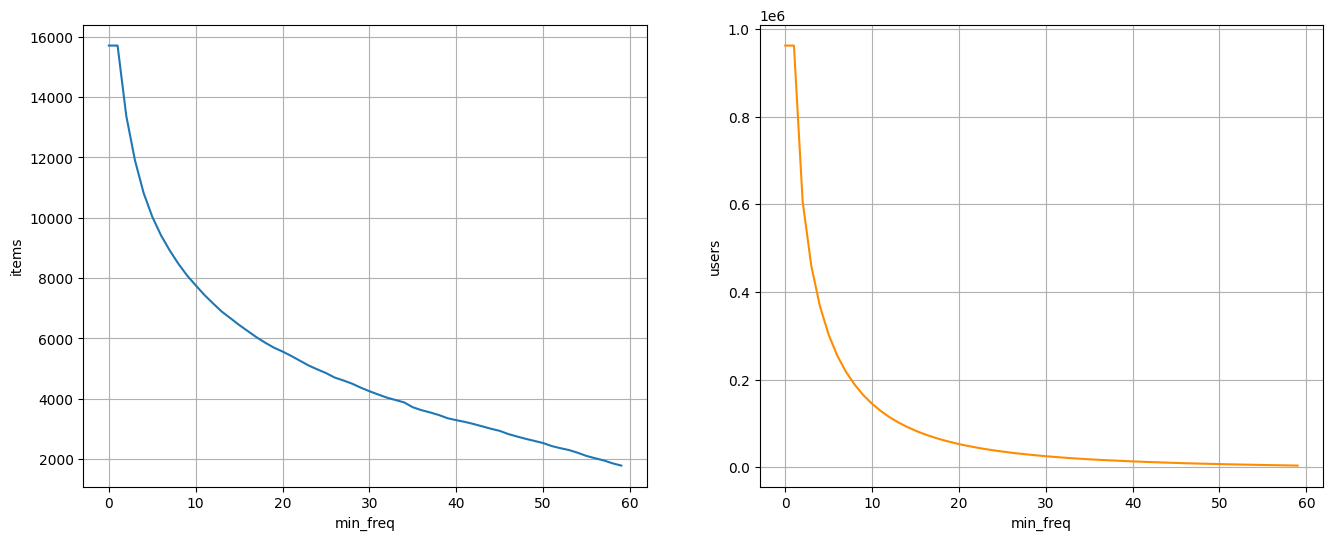

In [40]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(min_freq_range, items_)
plt.grid(True)
plt.xlabel('min_freq')
plt.ylabel('items')
plt.subplot(1, 2, 2)
plt.plot(min_freq_range, users, color='darkorange')
plt.grid(True)
plt.xlabel('min_freq')
plt.ylabel('users')

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [41]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=100):

    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)

    return B

w = fit_ease(matrix)

CPU times: total: 2.94 s
Wall time: 695 ms


In [42]:
w.shape

(3102, 3102)

Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [43]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]

    return decoded

joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recent_recs,ease_preds
0,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 10440, 13865, 142, 4151, 9728, 9996, 3..."
1,321,"[(1844, 51), (8373, 52), (13018, 53), (8437, 5...","[(8335, 162)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 13865, 10440, 8636, 3734, 4880, 15915, ..."
2,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[16166, 3734, 10119, 12743, 10605, 7571, 8254,..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 3734, 12995, 15297, 8636, 2657, ..."
4,571,"[(7149, 0), (10169, 5), (5931, 11), (4606, 11)...","[(4567, 156), (3071, 157), (14461, 159), (212,...","[2012, 956, 2059]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[15297, 10440, 8636, 13865, 142, 9728, 4495, 9..."


In [44]:
import numpy as np
import scipy.sparse as sps

def get_preds_batch(train_interactions, item2id, id2item, w):

    rows = []
    cols = []
    data = []
    for user_idx, x in enumerate(train_interactions):
        user_items = [t[0] for t in x]
        encoded = [item2id[t] for t in user_items if t in item2id]
        rows.extend([user_idx] * len(encoded))
        cols.extend(encoded)
        data.extend([1] * len(encoded))
    
    user_interaction_matrix = sps.csr_matrix((data, (rows, cols)), shape=(len(train_interactions), len(item2id)))
    
    preds = user_interaction_matrix.dot(w)
    
    if isinstance(preds, np.matrix):
        preds = np.array(preds)
    
    for user_idx, x in enumerate(train_interactions):
        user_items = [t[0] for t in x]
        encoded = [item2id[t] for t in user_items if t in item2id]
        preds[user_idx, encoded] = -np.inf
    
    # Ранжируем и декодируем топ-100 для каждого пользователя
    decoded_preds = []
    for user_idx in range(len(train_interactions)):
        ranks = np.argsort(-preds[user_idx])
        decoded = [id2item[t] for t in ranks[:100]]
        decoded_preds.append(decoded)
    
    return decoded_preds

# Применяем к данным
preds_list = get_preds_batch(joined.train_interactions, item2id, id2item, w)
joined['ease_preds'] = preds_list

In [45]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.09152572155850197, 'mrr': 0.12020351852332371, 'hr': 0.5463}

In [46]:
evaluate_recommender(joined, model_preds='toppopular_recent_recs')

{'map': 0.06601546025447216, 'mrr': 0.08212507936507936, 'hr': 0.232}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [47]:
map_list = []
mrr_list = []
hr_list = []

reg_weights = np.logspace(0, 4, num=20)
for reg_weight in tqdm(reg_weights):
    w = fit_ease(matrix, reg_weight)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    # preds_list = [get_preds(x, item2id, id2item) for x in joined.train_interactions]
    map_c, mrr_c, hr_c = evaluate_recommender(joined, model_preds="ease_preds").values()
    map_list.append(map_c)
    mrr_list.append(mrr_c)
    hr_list.append(hr_c)

100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


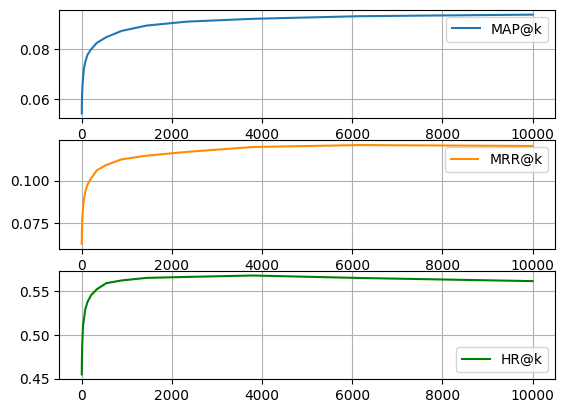

In [48]:
plt.subplot(3, 1, 1)
plt.plot(reg_weights, map_list, label='MAP@k')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(reg_weights, mrr_list, label='MRR@k', color = 'darkorange')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(reg_weights, hr_list, label='HR@k', color='green')
plt.grid(True)
plt.legend()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:** `Видно, что HR@k имеет максимум в районе 1e3, а другие метрики в этот момент уже почти вышли на асимптоту (или просто оооочень медленно растут), поэтому в данном случай reg_weight = 1e3 является оптимальным значением`

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** `до значения reg_weight = 1e3 все метрики растут очень быстро, затем достаточно быстро замедляются, а HR@k вообще начинает падать`

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

In [49]:
from tqdm import tqdm

In [50]:
topk = np.arange(1, 100, 5)
als = np.linspace(0.1, 1, 5)
min_freqs = np.arange(2, 20, 1)

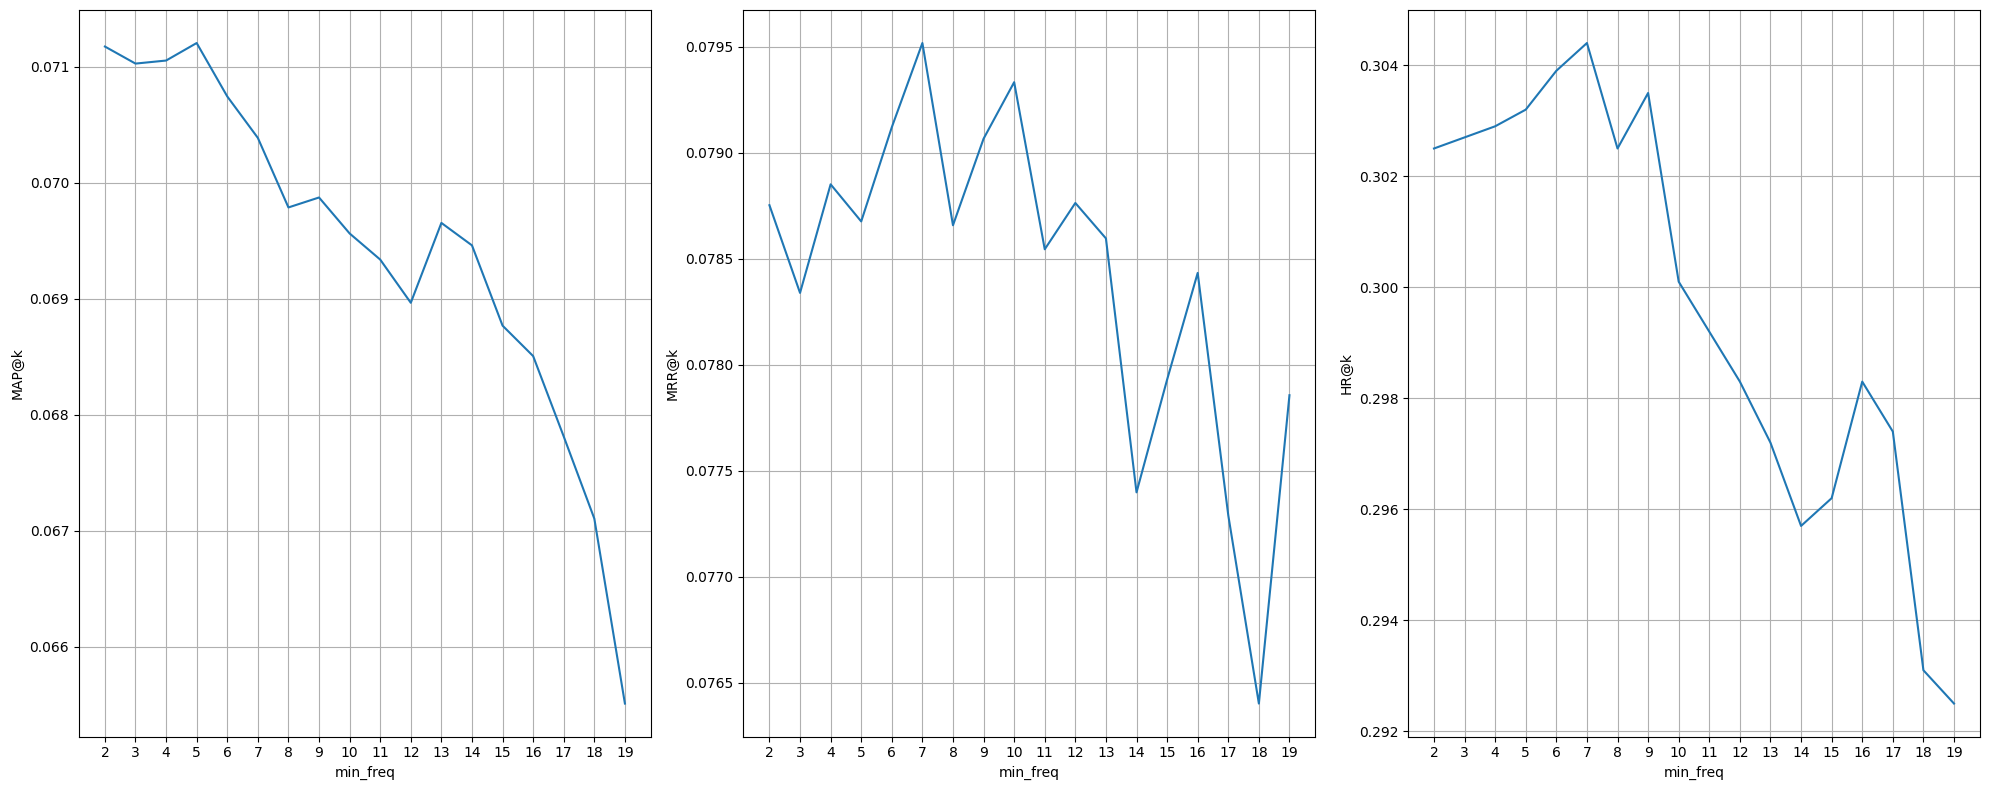

In [51]:
plt.figure(figsize=(20, 8))
# Создаем копии входных данных, чтобы избежать их изменения
train_df_copy = train_df.copy()
joined_copy = joined.copy()

map_list = []
mrr_list = []
hr_list = []
for min_freq in min_freqs:

    # Фильтрация данных (работаем с копией)
    filtered_train = filter_dataframe(train_df_copy, ['user_id', 'item_id'], min_freq=min_freq)
    filtered_train, item2id, user2id, id2item, id2user = df_encode(filtered_train)
    
    # Создание матрицы взаимодействий
    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id)),
    )
    
    w = fit_ease(matrix)
    
    joined_copy['ease_preds'] = joined_copy.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    
    map_c, _, _ = evaluate_recommender(joined_copy, model_preds='ease_preds', topn=k).values()
    _, mrr_c, hr_c = evaluate_recommender(joined_copy, model_preds='ease_preds', topn=k).values()
    map_list.append(map_c)
    mrr_list.append(mrr_c)
    hr_list.append(hr_c)

plt.subplot(1, 3, 1)
plt.plot(min_freqs, map_list)
plt.xticks(min_freqs)
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(min_freqs, mrr_list)
plt.xticks(min_freqs)
plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(min_freqs, hr_list)
plt.xticks(min_freqs)
plt.grid(True)

plt.subplot(1, 3, 1)
plt.xlabel('min_freq')
plt.ylabel('MAP@k')

plt.subplot(1, 3, 2)
plt.xlabel('min_freq')
plt.ylabel('MRR@k')

plt.subplot(1, 3, 3)
plt.xlabel('min_freq')
plt.ylabel('HR@k')

plt.tight_layout()
plt.show()

`Судя по графикам, с ослаблением требований к min_freq метрики должны увеличиваться, но не монотонно`

In [52]:
min_freqs = np.arange(2, 20, 4)
min_freqs

array([ 2,  6, 10, 14, 18])

5it [02:20, 28.02s/it]


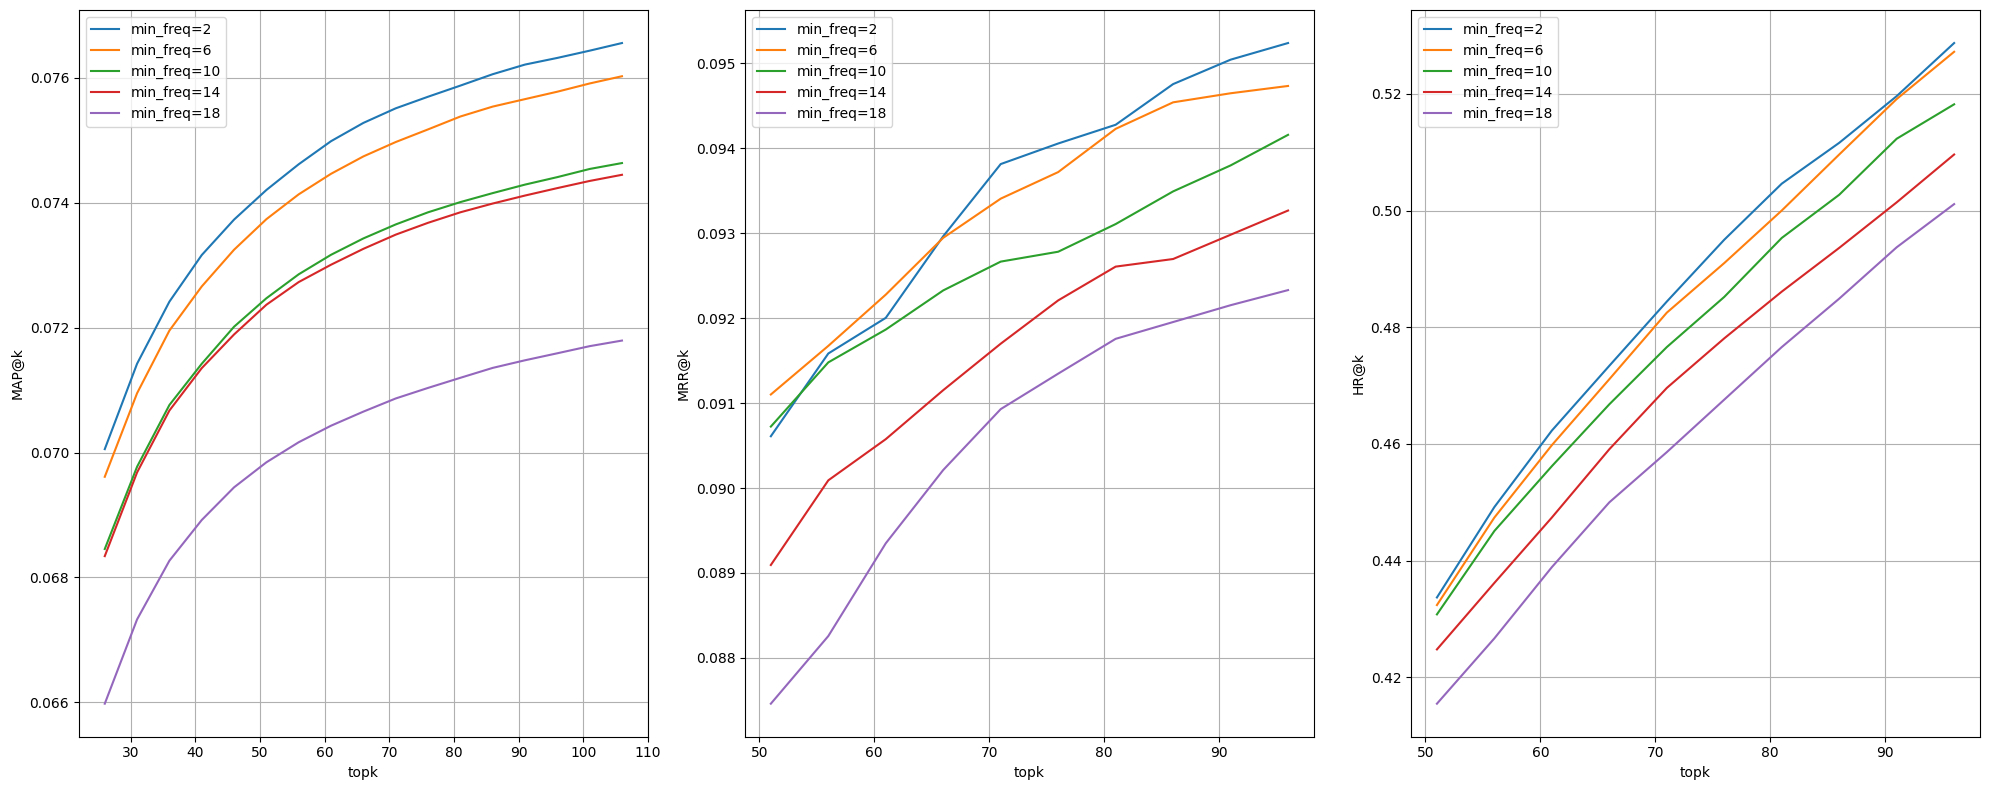

In [53]:
plt.figure(figsize=(20, 8))
# Создаем копии входных данных, чтобы избежать их изменения
train_df_copy = train_df.copy()
joined_copy = joined.copy()

for min_freq, al in tqdm(zip(min_freqs, als)):
    map_list = []
    mrr_list = []
    hr_list = []

    # Фильтрация данных (работаем с копией)
    filtered_train = filter_dataframe(train_df_copy, ['user_id', 'item_id'], min_freq=min_freq)
    filtered_train, item2id, user2id, id2item, id2user = df_encode(filtered_train)
    
    # Создание матрицы взаимодействий
    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id)),
    )
    
    w = fit_ease(matrix)
    
    joined_copy['ease_preds'] = joined_copy.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    
    for k in topk:
        map_c, _, _ = evaluate_recommender(joined_copy, model_preds='ease_preds', topn=k).values()
        _, mrr_c, hr_c = evaluate_recommender(joined_copy, model_preds='ease_preds', topn=k+50).values()
        map_list.append(map_c)
        mrr_list.append(mrr_c)
        hr_list.append(hr_c)

    plt.subplot(1, 3, 1)
    plt.plot(topk[3:]+10, map_list[3:], label=f'min_freq={min_freq}')
    
    
    plt.subplot(1, 3, 2)
    plt.plot((topk + 50)[:10], mrr_list[:10], label=f'min_freq={min_freq}')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot((topk+50)[:10], hr_list[:10], label=f'min_freq={min_freq}')
    plt.legend()


plt.subplot(1, 3, 1)
plt.xlabel('topk')
plt.ylabel('MAP@k')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.xlabel('topk')
plt.ylabel('MRR@k')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.xlabel('topk')
plt.ylabel('HR@k')
plt.legend()
plt.grid(True)

plt.tight_layout()
# plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** `В целом, верно, что качество модели увеличивается при уменьшеии min_freq, но, как было сказано ранее, не монотонно`

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [54]:
topk = 5

In [55]:
train_items = items[items.item_id.isin(item2id.keys())]
w = np.array(w)

In [56]:
sampled_item_ids = np.random.choice(list(train_items.item_id), size=10, replace=False)
results = []
for item_id in sampled_item_ids:
    
    item_name = items[items['item_id'] == item_id]['title'].values[0]
    item_idx = item2id[item_id]

    item_weights = w[item_idx, :]

    topk_indices = np.argsort(-item_weights)[:topk]

    topk_items = np.array([id2item[x] for x in topk_indices])

    recommendations = list(items[items.item_id.isin(topk_items)]['title'])
    
    # print(f"Рекомендации для фильма '{item_name}':")
    # for rec in recommendations:
    #     print(f"  - {rec}")
    # print()
    results.append({
        'фильм': item_name,
        'рек. 1': recommendations[0],
        'рек. 2': recommendations[1],
        'рек. 3': recommendations[2],
        'рек. 4': recommendations[3],
        'рек. 5': recommendations[4],
    })

results_df = pd.DataFrame(results)

results_df

,фильм,рек. 1,рек. 2,рек. 3,рек. 4,рек. 5
0,[4К] Индонезия. Тайны леса,Хрустальный,Драка в блоке 99,Пираты по соседству,Миньоны,2040: Будущее ждёт
1,Сокровище Амазонки,Тайное влечение,Люди Икс,Джуманджи: Зов джунглей,Скала,Зверополис
2,Игры судьбы,Любовь между строк,Девятаев,Помни меня,Королевский Гамбит,Взаперти
3,Мальчишник в Тайланде,Анатомия страсти,Аладдин,2067: Петля времени,Ледяной капкан,Возвращение героя
4,Doom: Аннигиляция,Пандемия,Эбигейл,Варкрафт,Гримм,Брешь
5,Терминатор 3: Восстание машин,Звёздные войны: Атака клонов,Звёздные войны: Эпизод 4 — Новая надежда,Чужой против Хищника,Амнезия,Терминатор: Да придёт спаситель
6,Терминатор: Тёмные судьбы,Клуб «Кастет»,Хищник,Мстители,Хищники,Мстители: Война бесконечности
7,Снежная Королева,100% волк,Рататуй,Холодное сердце,Мстители: Война бесконечности,Холодное сердце II
8,Мастера секса,Студентка по вызову,Клиника счастья,Простые сложности,Любовь,Секс и ничего лишнего
9,Будь здоров!,Три богатыря. На дальних берегах,Чем заняться дома?,Холодное сердце,История игрушек: Большой побег,Хороший доктор


Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** `Я смотрел на все эти фильмы, но к фильму с индексом 8 рекомедации подходят очень хорошо. К терминатору рекомендуются боевики и блокбастеры. А к мультику 'Будь здоров!' рекоммендуются мультики. 'Петля времени' и 'Алладин' в рекомедациях к одному и тому же фильму выглядят скорее как плохой результат`